In [98]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import geopandas as gpd 
from shapely.geometry import Point
import math
import numpy as np
import os
import os.path
import shutil
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import statsmodels.api as sm


In [63]:
aus = pd.read_csv('../data/austin_tx/austin_tx_info.csv')
aus1 = pd.read_csv('../data/austin_tx/austin_tx_units.csv')

In [64]:
aus.head()

,Address,Amenities,Neighborhood,NeighborhoodLink,PropertyId,PropertyName,PropertyUrl,ReviewScore,VerifiedListing,is_single_unit
0,8800 N Interstate 35,"['Package Service', 'Laundry Facilities', 'Con...",Austin,https://www.apartments.com/austin-tx/,vsqwbgg,Starburst Apartments,https://www.apartments.com/starburst-apartment...,3.9,verified,0
1,8312 N Interstate 35,"['Renovated Unit', 'Laundry Facilities', 'Main...",Georgian Acres,https://www.apartments.com/georgian-acres-aust...,cmlfp5d,Woodland Heights,https://www.apartments.com/woodland-heights-au...,3.6,verified,0
2,8405 Old Bee Cave Rd,"['Hiking Trails', 'patio/balcony', 'Close to M...",West Oak Hill,https://www.apartments.com/west-oak-hill-austi...,lmxceme,Southwest Trails,https://www.apartments.com/southwest-trails-au...,4.0,verified,0
3,5800 Brodie Ln,"['Package Service', 'Washer And Dryer', 'Bike ...",Sunset Valley,https://www.apartments.com/sunset-valley-austi...,e4fs7cn,MAA Sunset Valley,https://www.apartments.com/maa-sunset-valley-a...,4.1,verified,0
4,2301 S MoPac Expy,"['Bike Racks', 'Grilling Area', 'Stainless Ste...",Barton Creek,https://www.apartments.com/barton-creek-austin...,esem3bq,Gables at the Terrace,https://www.apartments.com/gables-at-the-terra...,4.1,verified,0


In [67]:
aus1.head()

,Baths,Beds,MaxRent,Model,PropertyId,SquareFootage
0,1.0,1,959.0,A -1BR/1BA small,cmlfp5d,536
1,1.0,1,1159.0,A -1BR/1BA small,cmlfp5d,536
2,1.0,1,979.0,C- 1BR/1BA,cmlfp5d,660
3,1.0,1,1259.0,B -1BR/1BA washer / dryer hook ups,cmlfp5d,660
4,1.0,1,1059.0,B -1BR/1BA washer / dryer hook ups,cmlfp5d,660


In [73]:
aus1.dtypes

Baths            float64
Beds               int64
MaxRent          float64
Model             object
PropertyId        object
SquareFootage    float64
dtype: object

In [68]:
# convert rent and sq. footage to float type
aus1['MaxRent'] = aus1['MaxRent'].astype(float)
aus1['SquareFootage'] = aus1['SquareFootage'].astype(str)
aus1['SquareFootage'] = aus1['SquareFootage'].str.replace(',','').astype(float)


In [85]:
#drop na for desired columns
#aus1['MaxRent'] = aus1['MaxRent'].dropna()
#aus1['SquareFootage'] = aus1['SquareFootage'].dropna()
aus1 = aus1.dropna(subset=['MaxRent'])
aus1 = aus1.dropna(subset=['SquareFootage'])


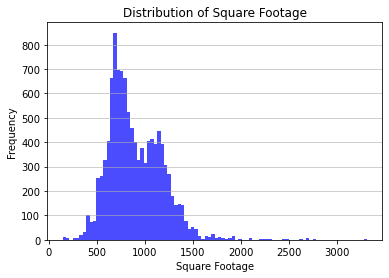

In [132]:
# check distribution of square footage
plt.hist(aus1['SquareFootage'], bins='auto', color='blue', alpha=0.7)
plt.title('Distribution of Square Footage')
plt.xlabel('Square Footage')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

Text(0.5, 1.0, 'Rent vs. Square Footage')

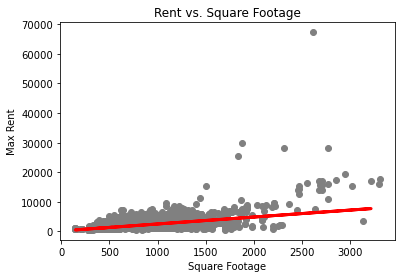

In [90]:
X = aus1[['SquareFootage']].values
y = aus1['MaxRent'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

plt.scatter(aus1['SquareFootage'], aus1['MaxRent'], color='grey')
plt.plot(X_test, y_pred, color='red', linewidth=3, label='Predicted Rent')
plt.xlabel('Square Footage')
plt.ylabel('Max Rent')
plt.title('Rent vs. Square Footage')

In [95]:
# Calculate R-squared value
r2_value = r2_score(y_test, y_pred)
print("R-squared value:", r2_value)
# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)

R-squared value: 0.2543895895639864
Mean Squared Error (MSE): 1094455.5672714536
Mean Absolute Error (MAE): 693.6991688347227


In [105]:
#calculate standardized residual for outliers
aus1["predicted_rent"] = model.predict(aus1[["SquareFootage"]])
aus1["Residual"] = aus1["MaxRent"] - aus1["predicted_rent"]
mean = aus1["Residual"].mean()
std = aus1["Residual"].std()

aus1["StdResidual"] = (aus1["Residual"] - mean)/std

/Users/nikkosiegfried/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


Text(0, 0.5, 'Studentized Residuals')

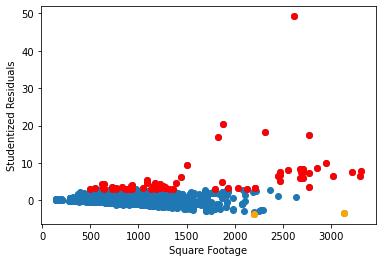

In [133]:
#plot point with standardized residuals outside of -3,3 to identify potential outliers
plt.scatter(aus1['SquareFootage'], aus1['StdResidual'])
plt.scatter(aus1[aus1['StdResidual']>3].SquareFootage, aus1[aus1['StdResidual']>3].StdResidual, color='red')
plt.scatter(aus1[aus1['StdResidual']<-3].SquareFootage, aus1[aus1['StdResidual']<-3].StdResidual, color='orange')
plt.xlabel('Square Footage')
plt.ylabel('Studentized Residuals')